Computing analytical posterior...
Setting up HMC sampler...
Running HMC sampling...
Starting warmup...
Warmup 200/1000, accept_prob: 0.194, avg_accept: 0.611, epsilon: 0.0045
Warmup 400/1000, accept_prob: 0.872, avg_accept: 0.633, epsilon: 0.0045
Warmup 600/1000, accept_prob: 0.533, avg_accept: 0.656, epsilon: 0.0045
Warmup 800/1000, accept_prob: 0.380, avg_accept: 0.654, epsilon: 0.0045
Warmup 1000/1000, accept_prob: 1.000, avg_accept: 0.633, epsilon: 0.0045
Adapted mass matrix from 499 warmup samples
Final warmup epsilon: 0.0045
Starting sampling...
Sample 100/2000, Accept rate: 0.700
Sample 200/2000, Accept rate: 0.670
Sample 300/2000, Accept rate: 0.660
Sample 400/2000, Accept rate: 0.690
Sample 500/2000, Accept rate: 0.674
Sample 600/2000, Accept rate: 0.658
Sample 700/2000, Accept rate: 0.664
Sample 800/2000, Accept rate: 0.660
Sample 900/2000, Accept rate: 0.663
Sample 1000/2000, Accept rate: 0.660
Sample 1100/2000, Accept rate: 0.665
Sample 1200/2000, Accept rate: 0.669
Sample 

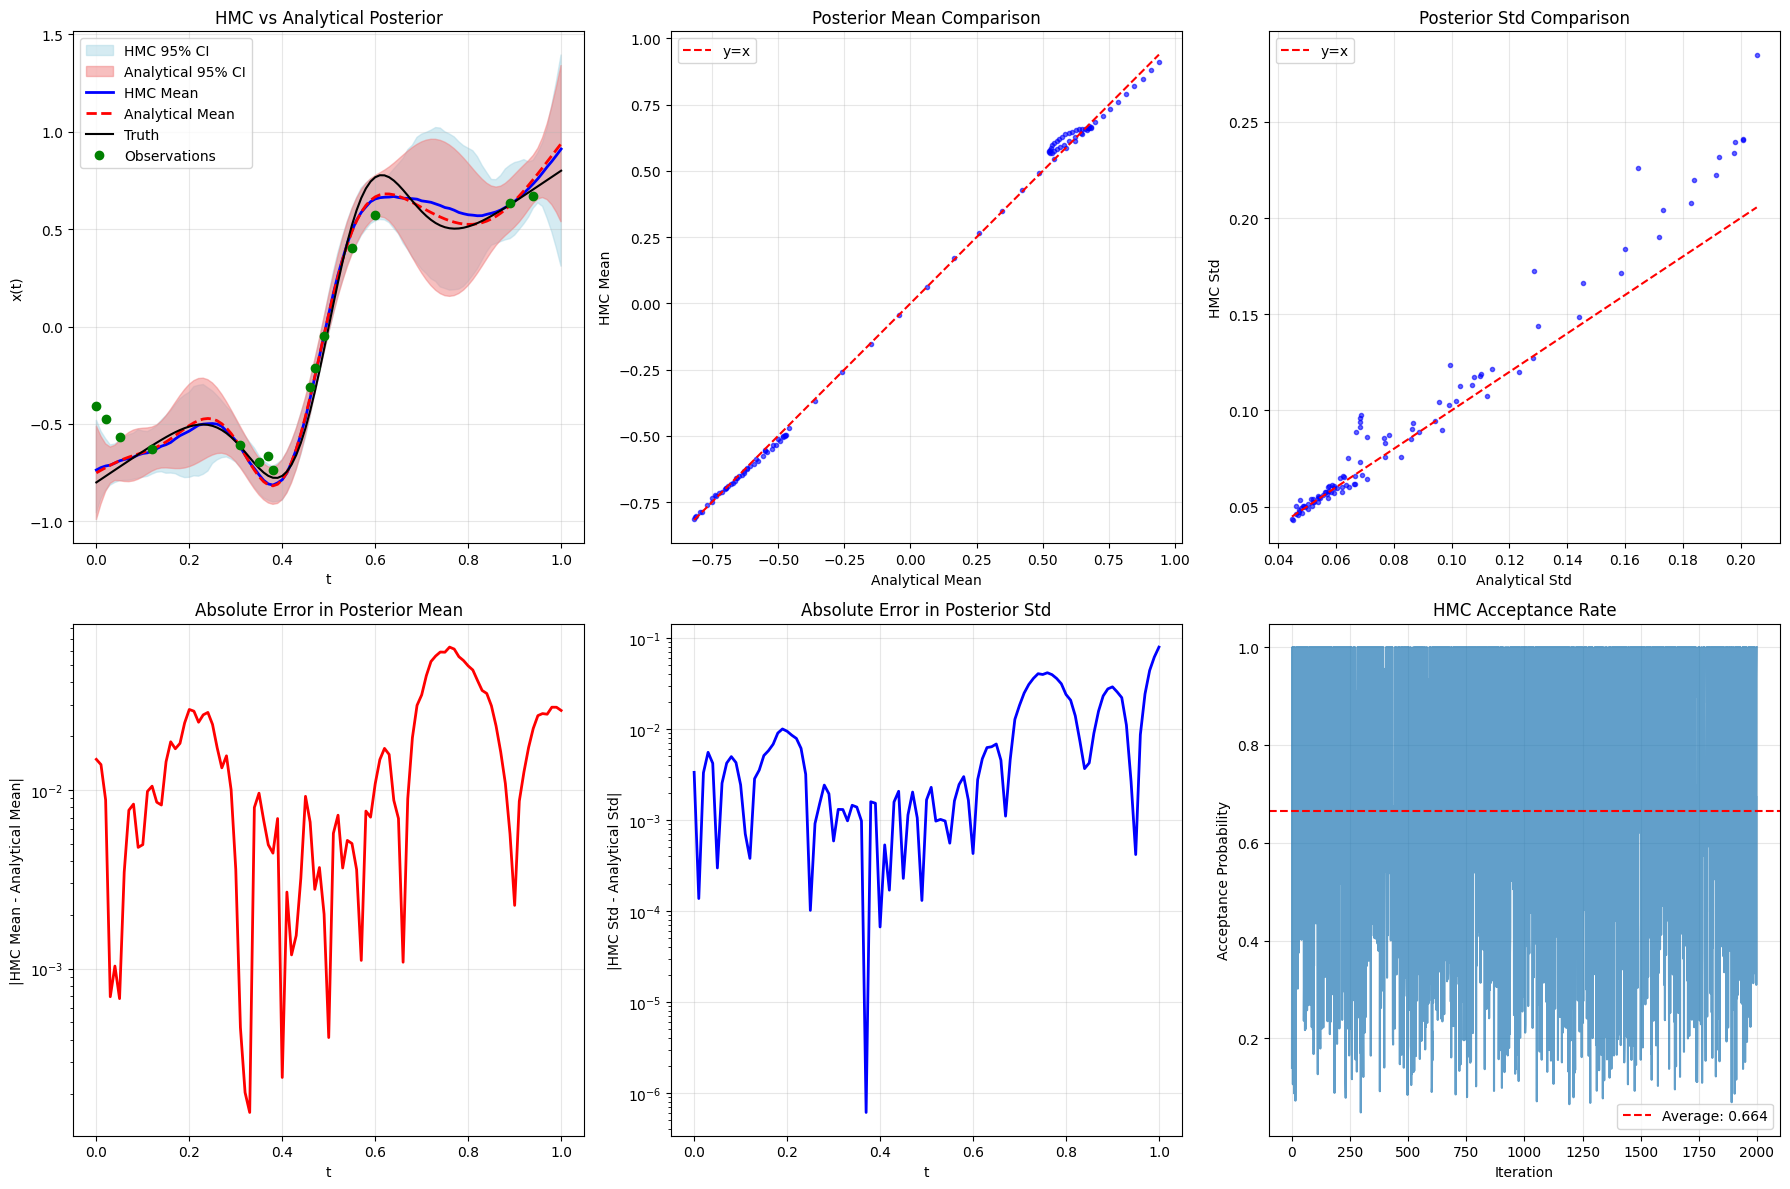


NUMERICAL COMPARISON: HMC vs Analytical
Posterior Mean:
  RMSE: 2.361700e-02
  Max absolute error: 6.284619e-02
  Relative RMSE: 3.813397e-02

Posterior Standard Deviation:
  RMSE: 1.748074e-02
  Max absolute error: 7.943321e-02
  Relative RMSE: 1.995642e-01

Posterior Variance (diagonal):
  RMSE: 6.834159e-03

Posterior Covariance (off-diagonal, first 10x10):
  RMSE: 5.107803e-04


In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.linalg import toeplitz

# Set JAX to use double precision for better numerical accuracy
jax.config.update("jax_enable_x64", True)

class JAXHMCDeblurring:
    """
    HMC sampler for Bayesian deblurring using JAX
    """
    
    def __init__(self, A_matrix, y_obs, sigma, L_matrix, gamma, initial_x):
        """
        Parameters:
        -----------
        A_matrix : array
            Forward operator (observation matrix)
        y_obs : array
            Observed data
        sigma : float
            Observation noise standard deviation
        L_matrix : array
            Prior precision matrix factor
        gamma : float
            Prior parameter
        initial_x : array
            Initial parameter guess
        """
        # Convert to JAX arrays
        self.A = jnp.array(A_matrix)
        self.y_obs = jnp.array(y_obs)
        self.sigma = sigma
        self.L = jnp.array(L_matrix)
        self.gamma = gamma
        self.x_init = jnp.array(initial_x)
        
        # HMC parameters
        self.epsilon = 0.01  # Step size
        self.n_leapfrog = 15  # Number of leapfrog steps
        self.mass_matrix = jnp.eye(len(initial_x))
        
        # Compile functions
        self._compile_functions()
        
    def _compile_functions(self):
        """Compile JAX functions for efficiency"""
        
        @jit
        def forward_operator(x):
            """
            Forward operator: x -> Ax
            This is where you would put your PDE solver for nonlinear problems
            """
            return self.A @ x
        
        @jit
        def log_likelihood(x):
            """Compute log-likelihood"""
            predictions = forward_operator(x)
            residual = predictions - self.y_obs
            return -0.5 * jnp.sum(residual**2) / self.sigma**2
        
        @jit
        def log_prior(x):
            """Compute log-prior using precision matrix"""
            Lx = self.L @ x
            return -0.5 * jnp.sum(Lx**2) / self.gamma**2
        
        @jit
        def log_posterior(x):
            """Compute log-posterior"""
            return log_likelihood(x) + log_prior(x)
        
        # Store compiled functions
        self.forward_operator = forward_operator
        self.log_posterior_fn = log_posterior
        self.grad_log_posterior_fn = jit(grad(log_posterior))
        
        # Combined function for efficiency
        @jit
        def log_posterior_and_grad(x):
            return log_posterior(x), grad(log_posterior)(x)
        
        self.log_posterior_and_grad_fn = log_posterior_and_grad
    
    @partial(jit, static_argnums=(0,))
    def leapfrog_step(self, x, momentum, epsilon):
        """Single leapfrog integration step"""
        
        # Half step for momentum
        _, grad_x = self.log_posterior_and_grad_fn(x)
        momentum = momentum + 0.5 * epsilon * grad_x
        
        # Full step for position
        mass_inv = jnp.linalg.solve(self.mass_matrix, momentum)
        x = x + epsilon * mass_inv
        
        # Half step for momentum
        _, grad_x = self.log_posterior_and_grad_fn(x)
        momentum = momentum + 0.5 * epsilon * grad_x
        
        return x, momentum
    
    @partial(jit, static_argnums=(0,))
    def compute_energy(self, x, momentum):
        """Compute Hamiltonian energy"""
        log_p = self.log_posterior_fn(x)
        kinetic = 0.5 * jnp.dot(momentum, jnp.linalg.solve(self.mass_matrix, momentum))
        return -log_p + kinetic
    
    def hmc_step(self, x_current, key):
        """Complete HMC step"""
        
        # Sample momentum
        key, subkey = random.split(key)
        momentum = random.normal(subkey, shape=x_current.shape)
        
        # Current energy
        energy_current = self.compute_energy(x_current, momentum)
        
        # Leapfrog trajectory
        x_prop = x_current
        momentum_prop = momentum
        
        for _ in range(self.n_leapfrog):
            x_prop, momentum_prop = self.leapfrog_step(
                x_prop, momentum_prop, self.epsilon
            )
        
        # Negate momentum for reversibility
        momentum_prop = -momentum_prop
        
        # Proposed energy
        energy_prop = self.compute_energy(x_prop, momentum_prop)
        
        # Accept/reject
        delta_energy = energy_prop - energy_current
        accept_prob = jnp.minimum(1.0, jnp.exp(-delta_energy))
        
        key, subkey = random.split(key)
        accept = random.uniform(subkey) < accept_prob
        
        x_new = jnp.where(accept, x_prop, x_current)
        
        return x_new, accept, accept_prob, energy_current, key
    
    def sample(self, n_samples, n_warmup=1000, seed=42, target_accept=0.65):
        """
        Run HMC sampling with adaptation
        """
        
        key = random.PRNGKey(seed)
        x = self.x_init.copy()
        
        # Storage
        samples = []
        accept_rates = []
        energies = []
        
        print("Starting warmup...")
        warmup_samples = []
        step_sizes = []
        
        # Warmup phase with step size adaptation
        for i in range(n_warmup):
            x, accepted, accept_prob, energy, key = self.hmc_step(x, key)
            
            # Store for mass matrix adaptation
            if i > n_warmup // 2:
                warmup_samples.append(x)
            
            # Dual averaging for step size adaptation
            if i < n_warmup - 100:
                eta = 1.0 / (i + 10)  # Adaptation rate
                self.epsilon *= jnp.exp(eta * (accept_prob - target_accept))
                self.epsilon = jnp.clip(self.epsilon, 1e-5, 1.0)
            
            step_sizes.append(self.epsilon)
            
            if (i + 1) % 200 == 0:
                recent_accepts = accept_rates[-200:] if len(accept_rates) >= 200 else accept_rates
                avg_accept = np.mean(recent_accepts) if recent_accepts else accept_prob
                print(f"Warmup {i+1}/{n_warmup}, "
                      f"accept_prob: {accept_prob:.3f}, "
                      f"avg_accept: {avg_accept:.3f}, "
                      f"epsilon: {self.epsilon:.4f}")
            
            accept_rates.append(accept_prob)
        
        # Adapt mass matrix from warmup samples
        if len(warmup_samples) > 100:
            warmup_array = jnp.array(warmup_samples)
            sample_cov = jnp.cov(warmup_array.T)
            # Add regularization
            regularization = 1e-6 * jnp.eye(sample_cov.shape[0])
            self.mass_matrix = sample_cov + regularization
            print(f"Adapted mass matrix from {len(warmup_samples)} warmup samples")
        
        print(f"Final warmup epsilon: {self.epsilon:.4f}")
        print("Starting sampling...")
        
        # Reset counters for sampling phase
        accept_rates = []
        total_accepted = 0
        
        # Sampling phase
        for i in range(n_samples):
            x, accepted, accept_prob, energy, key = self.hmc_step(x, key)
            
            samples.append(x)
            accept_rates.append(accept_prob)
            energies.append(energy)
            total_accepted += accepted
            
            if (i + 1) % 100 == 0:
                current_accept_rate = total_accepted / (i + 1)
                print(f"Sample {i+1}/{n_samples}, "
                      f"Accept rate: {current_accept_rate:.3f}")
        
        samples = jnp.array(samples)
        
        # Diagnostics
        diagnostics = {
            'accept_rate': total_accepted / n_samples,
            'accept_probs': jnp.array(accept_rates),
            'energies': jnp.array(energies),
            'final_epsilon': self.epsilon,
            'final_mass_matrix': self.mass_matrix,
            'step_sizes_warmup': step_sizes
        }
        
        return samples, diagnostics
    
    def posterior_predictive(self, samples, n_pred=None):
        """Generate posterior predictive samples"""
        if n_pred is None:
            n_pred = len(samples)
        
        # Select random subset of samples
        key = random.PRNGKey(0)
        indices = random.choice(key, len(samples), shape=(n_pred,), replace=True)
        selected_samples = samples[indices]
        
        # Vectorized forward operator
        predictions = vmap(self.forward_operator)(selected_samples)
        
        return predictions


def compute_analytical_posterior(A, y_obs, sigma, L, gamma):
    """
    Compute the analytical posterior for linear Gaussian inverse problem
    
    For the model:
    y = Ax + ε, ε ~ N(0, σ²I)
    x ~ N(0, (γ²/L^T L)^{-1})
    
    The posterior is:
    x|y ~ N(μ_post, Γ_post)
    where:
    Γ_post^{-1} = A^T A / σ² + L^T L / γ²
    μ_post = Γ_post A^T y / σ²
    """
    from scipy.linalg import inv
    
    # Posterior precision matrix
    precision_post = (1/sigma**2) * A.T @ A + (1/gamma**2) * L.T @ L
    
    # Posterior covariance matrix
    cov_post = inv(precision_post)
    
    # Posterior mean
    mean_post = cov_post @ ((1/sigma**2) * A.T @ y_obs)
    
    return mean_post, cov_post


def plot_hmc_vs_analytical(t, hmc_samples, xtrue, t_obs, y_obs, diagnostics, 
                          analytical_mean, analytical_cov):
    """Plot comparison between HMC and analytical results"""
    
    # Compute HMC statistics
    hmc_mean = np.mean(hmc_samples, axis=0)
    hmc_std = np.std(hmc_samples, axis=0)
    hmc_q025 = np.percentile(hmc_samples, 2.5, axis=0)
    hmc_q975 = np.percentile(hmc_samples, 97.5, axis=0)
    
    # Compute analytical statistics
    analytical_std = np.sqrt(np.diag(analytical_cov))
    analytical_q025 = analytical_mean - 1.96 * analytical_std
    analytical_q975 = analytical_mean + 1.96 * analytical_std
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Main reconstruction comparison
    ax = axes[0, 0]
    
    # HMC uncertainty
    t_fill = np.concatenate([t, t[::-1]])
    hmc_fill = np.concatenate([hmc_q025, hmc_q975[::-1]])
    ax.fill(t_fill, hmc_fill, color='lightblue', alpha=0.5, label='HMC 95% CI')
    
    # Analytical uncertainty
    analytical_fill = np.concatenate([analytical_q025, analytical_q975[::-1]])
    ax.fill(t_fill, analytical_fill, color='lightcoral', alpha=0.5, label='Analytical 95% CI')
    
    # Means
    ax.plot(t, hmc_mean, 'b-', linewidth=2, label='HMC Mean')
    ax.plot(t, analytical_mean, 'r--', linewidth=2, label='Analytical Mean')
    ax.plot(t, xtrue, 'k-', linewidth=1.5, label='Truth')
    ax.plot(t_obs, y_obs, 'go', markersize=6, label='Observations')
    
    ax.legend()
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    ax.set_title('HMC vs Analytical Posterior')
    ax.grid(True, alpha=0.3)
    
    # Mean comparison
    ax = axes[0, 1]
    ax.plot(analytical_mean, hmc_mean, 'b.', alpha=0.6)
    ax.plot([analytical_mean.min(), analytical_mean.max()], 
            [analytical_mean.min(), analytical_mean.max()], 'r--', label='y=x')
    ax.set_xlabel('Analytical Mean')
    ax.set_ylabel('HMC Mean')
    ax.set_title('Posterior Mean Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Standard deviation comparison
    ax = axes[0, 2]
    ax.plot(analytical_std, hmc_std, 'b.', alpha=0.6)
    ax.plot([analytical_std.min(), analytical_std.max()], 
            [analytical_std.min(), analytical_std.max()], 'r--', label='y=x')
    ax.set_xlabel('Analytical Std')
    ax.set_ylabel('HMC Std')
    ax.set_title('Posterior Std Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Error in mean
    ax = axes[1, 0]
    mean_error = np.abs(hmc_mean - analytical_mean)
    ax.plot(t, mean_error, 'r-', linewidth=2)
    ax.set_xlabel('t')
    ax.set_ylabel('|HMC Mean - Analytical Mean|')
    ax.set_title('Absolute Error in Posterior Mean')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Error in standard deviation
    ax = axes[1, 1]
    std_error = np.abs(hmc_std - analytical_std)
    ax.plot(t, std_error, 'b-', linewidth=2)
    ax.set_xlabel('t')
    ax.set_ylabel('|HMC Std - Analytical Std|')
    ax.set_title('Absolute Error in Posterior Std')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # HMC diagnostics
    ax = axes[1, 2]
    ax.plot(diagnostics['accept_probs'], alpha=0.7)
    ax.axhline(y=diagnostics['accept_rate'], color='red', linestyle='--', 
               label=f"Average: {diagnostics['accept_rate']:.3f}")
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Acceptance Probability')
    ax.set_title('HMC Acceptance Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparisons
    print("\n" + "="*60)
    print("NUMERICAL COMPARISON: HMC vs Analytical")
    print("="*60)
    
    # Mean comparison
    mean_rmse = np.sqrt(np.mean((hmc_mean - analytical_mean)**2))
    mean_max_error = np.max(np.abs(hmc_mean - analytical_mean))
    print(f"Posterior Mean:")
    print(f"  RMSE: {mean_rmse:.6e}")
    print(f"  Max absolute error: {mean_max_error:.6e}")
    print(f"  Relative RMSE: {mean_rmse/np.std(analytical_mean):.6e}")
    
    # Standard deviation comparison
    std_rmse = np.sqrt(np.mean((hmc_std - analytical_std)**2))
    std_max_error = np.max(np.abs(hmc_std - analytical_std))
    print(f"\nPosterior Standard Deviation:")
    print(f"  RMSE: {std_rmse:.6e}")
    print(f"  Max absolute error: {std_max_error:.6e}")
    print(f"  Relative RMSE: {std_rmse/np.mean(analytical_std):.6e}")
    
    # Covariance matrix comparison (diagonal elements)
    cov_diag_analytical = np.diag(analytical_cov)
    cov_diag_hmc = np.var(hmc_samples, axis=0)
    cov_rmse = np.sqrt(np.mean((cov_diag_hmc - cov_diag_analytical)**2))
    print(f"\nPosterior Variance (diagonal):")
    print(f"  RMSE: {cov_rmse:.6e}")
    
    # Sample-based covariance vs analytical (a few off-diagonal elements)
    hmc_cov = np.cov(hmc_samples.T)
    n_test = min(10, len(analytical_mean))
    off_diag_analytical = []
    off_diag_hmc = []
    for i in range(n_test):
        for j in range(i+1, n_test):
            off_diag_analytical.append(analytical_cov[i, j])
            off_diag_hmc.append(hmc_cov[i, j])
    
    off_diag_rmse = np.sqrt(np.mean((np.array(off_diag_hmc) - np.array(off_diag_analytical))**2))
    print(f"\nPosterior Covariance (off-diagonal, first {n_test}x{n_test}):")
    print(f"  RMSE: {off_diag_rmse:.6e}")


def effective_sample_size(samples):
    """Compute effective sample size for each parameter"""
    from scipy import signal
    
    def ess_single_chain(x):
        """ESS for a single chain"""
        n = len(x)
        x = x - np.mean(x)
        
        # Auto-correlation function
        autocorr = signal.correlate(x, x, mode='full')
        autocorr = autocorr[n-1:]
        autocorr = autocorr / autocorr[0]
        
        # Find first negative autocorrelation
        first_negative = np.where(autocorr < 0)[0]
        if len(first_negative) > 0:
            cutoff = first_negative[0]
        else:
            cutoff = len(autocorr)
        
        # Sum autocorrelations up to cutoff
        sum_autocorr = 2 * np.sum(autocorr[1:cutoff]) + 1
        
        return n / sum_autocorr if sum_autocorr > 0 else n
    
    # Compute ESS for each parameter
    ess_values = []
    for i in range(samples.shape[1]):
        ess_values.append(ess_single_chain(samples[:, i]))
    
    return np.array(ess_values)


def main():
    """Main function to run the HMC deblurring example"""
    
    # Set random seed for reproducibility  
    np.random.seed(20)
    
    # Setup problem (same as your original code)
    n = 100
    s = np.linspace(0, 1, n+1)
    t = s.copy()
    
    # Sparse observation settings
    n_obs = 15
    obs_indices = np.sort(np.random.choice(n+1, n_obs, replace=False))
    t_obs = t[obs_indices]
    
    # Prior settings
    PriorFlag = 2
    
    # Discretize the deblurring kernel
    beta = 0.05
    a = (1/np.sqrt(2*np.pi*beta**2)) * np.exp(-0.5*(1/beta**2)*t**2)
    A_full = (1/n) * toeplitz(a)
    A = A_full[obs_indices, :]  # Sparse observation matrix
    
    # Truth
    xtrue = 10*(t-0.5)*np.exp(-0.5*1e2*(t-0.5)**2) - 0.8 + 1.6*t
    
    # Generate observations with noise
    noise = 5
    y0_full = A_full @ xtrue
    y0 = y0_full[obs_indices]
    sigma = np.max(np.abs(y0_full)) * noise / 100
    y_obs = y0 + sigma * np.random.randn(n_obs)
    
    # Prior construction
    gamma = 1/n
    
    if PriorFlag == 1:
        L = (np.diag(np.ones(n+1)) - 
             np.diag(0.5*np.ones(n), 1) - 
             np.diag(0.5*np.ones(n), -1))
    elif PriorFlag == 2:
        from scipy.linalg import inv
        L_D = (np.diag(np.ones(n+1)) - 
               np.diag(0.5*np.ones(n), 1) - 
               np.diag(0.5*np.ones(n), -1))
        
        L_Dinv = inv(L_D)
        Dev = np.sqrt(gamma**2 * np.diag(L_Dinv @ L_Dinv.T))
        
        delta = gamma / Dev[n//2]
        L = L_D.copy()
        L[0, :] = 0
        L[0, 0] = delta
        L[-1, :] = 0
        L[-1, -1] = delta
    
    # Compute analytical posterior solution
    print("Computing analytical posterior...")
    analytical_mean, analytical_cov = compute_analytical_posterior(A, y_obs, sigma, L, gamma)
    
    # Get MAP estimate as initial point for HMC (should equal analytical mean)
    A_aug = np.vstack([(1/sigma)*A, (1/gamma)*L])
    b_aug = np.concatenate([(1/sigma)*y_obs, np.zeros(n+1)])
    x_map = np.linalg.lstsq(A_aug, b_aug, rcond=None)[0]
    
    print("Setting up HMC sampler...")
    
    # Initialize HMC sampler
    sampler = JAXHMCDeblurring(
        A_matrix=A,
        y_obs=y_obs,
        sigma=sigma,
        L_matrix=L,
        gamma=gamma,
        initial_x=x_map  # Start from MAP estimate
    )
    
    # Run HMC sampling
    print("Running HMC sampling...")
    samples, diagnostics = sampler.sample(
        n_samples=2000,  # More samples for better comparison
        n_warmup=1000,
        seed=42
    )
    
    # Print results
    print(f"\nSampling completed!")
    print(f"Final acceptance rate: {diagnostics['accept_rate']:.3f}")
    print(f"Final step size: {diagnostics['final_epsilon']:.4f}")
    
    # Compute HMC posterior statistics
    hmc_mean = np.mean(samples, axis=0)
    hmc_std = np.std(samples, axis=0)
    
    print(f"\nFirst 5 elements comparison:")
    print(f"Truth:           {xtrue[:5]}")
    print(f"Analytical mean: {analytical_mean[:5]}")
    print(f"HMC mean:        {hmc_mean[:5]}")
    print(f"MAP estimate:    {x_map[:5]}")
    
    # Compute effective sample size
    ess = effective_sample_size(samples)
    print(f"\nEffective sample size statistics:")
    print(f"  Mean ESS: {np.mean(ess):.1f}")
    print(f"  Min ESS:  {np.min(ess):.1f}")
    print(f"  Max ESS:  {np.max(ess):.1f}")
    
    # Verification that MAP = analytical mean (should be very close)
    map_analytical_error = np.max(np.abs(x_map - analytical_mean))
    print(f"\nMAP vs Analytical mean max error: {map_analytical_error:.2e}")
    print("(Should be very small - confirms analytical solution)")
    
    # Plot comprehensive comparison
    plot_hmc_vs_analytical(t, samples, xtrue, t_obs, y_obs, diagnostics, 
                          analytical_mean, analytical_cov)
    
    return samples, diagnostics, sampler, analytical_mean, analytical_cov


if __name__ == "__main__":
    samples, diagnostics, sampler, analytical_mean, analytical_cov = main()